In [1]:
# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import chi2, r_regression
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM,Dropout, BatchNormalization, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam

In [2]:
data=yf.download('0005.hk')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,111.0,111.5,107.50,108.0,55.387093,3908164
2000-01-04,106.0,106.5,105.00,106.0,54.361382,6895378
2000-01-05,101.0,102.0,99.50,100.5,51.540741,14657098
2000-01-06,101.0,102.0,96.25,97.0,49.745789,10632084
2000-01-07,98.5,101.0,97.50,100.5,51.540741,8368286


In [3]:
data['Prediction']=data['Close'].shift(-1)
data.drop('Adj Close',1,inplace=True)
data.head()

,Open,High,Low,Close,Volume,Prediction
Date,,,,,,
2000-01-03,111.0,111.5,107.50,108.0,3908164,106.0
2000-01-04,106.0,106.5,105.00,106.0,6895378,100.5
2000-01-05,101.0,102.0,99.50,100.5,14657098,97.0
2000-01-06,101.0,102.0,96.25,97.0,10632084,100.5
2000-01-07,98.5,101.0,97.50,100.5,8368286,100.0


In [4]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MTM6']=talib.MOM(data['Close'],timeperiod=6)
data['MTM12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data.head()

,Open,High,Low,Close,Volume,Prediction,6day MA,12day MA,RSI,%R5,%R10,MTM6,MTM12,EMA12,EMA26,MACD,TR,OSC6,OSC12
Date,,,,,,,,,,,,,,,,,,,
2000-01-03,111.0,111.5,107.50,108.0,3908164,106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,106.0,106.5,105.00,106.0,6895378,100.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,NaN,NaN
2000-01-05,101.0,102.0,99.50,100.5,14657098,97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.50,NaN,NaN
2000-01-06,101.0,102.0,96.25,97.0,10632084,100.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.75,NaN,NaN
2000-01-07,98.5,101.0,97.50,100.5,8368286,100.0,NaN,NaN,NaN,-72.131148,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN


In [5]:
data.dropna(inplace=True)
data

,Open,High,Low,Close,Volume,Prediction,6day MA,12day MA,RSI,%R5,%R10,MTM6,MTM12,EMA12,EMA26,MACD,TR,OSC6,OSC12
Date,,,,,,,,,,,,,,,,,,,
2000-02-18,93.000000,93.500000,90.500000,91.250000,10116832,89.500000,90.375000,90.479167,50.204183,-37.500000,-37.500000,1.500000,-0.750000,91.053042,93.063655,-2.141415,3.000000,3.011926,-12.789952
2000-02-21,90.000000,91.000000,88.500000,89.500000,8839331,88.750000,90.250000,90.312500,42.389337,-59.375000,-59.375000,-0.750000,-2.000000,90.814112,92.799680,-2.096247,2.750000,-15.435632,-20.813717
2000-02-22,88.750000,89.000000,88.000000,88.750000,11567491,88.250000,90.458333,90.104167,39.328385,-88.000000,-68.750000,1.250000,-2.500000,90.496557,92.499704,-2.096799,1.500000,-22.567136,-24.079465
2000-02-23,87.750000,88.750000,87.500000,88.250000,15418845,90.250000,90.541667,89.854167,37.237017,-88.888889,-75.000000,0.500000,-3.000000,90.150933,92.184911,-2.113222,1.250000,-27.461036,-26.290292
2000-02-24,89.000000,90.500000,88.750000,90.250000,8222217,89.500000,90.166667,89.958333,49.715579,-54.166667,-50.000000,-2.250000,1.250000,90.166174,92.041584,-1.942463,2.250000,2.206474,-12.051833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-17,46.299999,46.750000,46.049999,46.400002,39799001,45.500000,45.216667,45.120833,70.328827,-13.461488,-13.461488,1.100002,2.900002,45.203886,45.146441,0.057445,1.599998,46.481870,24.298309
2021-12-20,45.799999,46.000000,45.349998,45.500000,16771986,45.450001,45.266667,45.245833,53.975526,-48.076951,-48.076951,0.299999,1.500000,45.249442,45.172630,0.076811,1.050003,8.149824,5.673022
2021-12-21,45.700001,45.750000,45.200001,45.450001,12301373,45.700001,45.325001,45.295834,53.174145,-53.061177,-50.000000,0.350002,0.600002,45.280297,45.193176,0.087121,0.549999,6.295463,4.722013


In [6]:
# Feature extraction
X=data.drop('Prediction',1)
Y=data['Prediction'].values.reshape(-1,1)
test = SelectKBest(score_func=r_regression, k=5)
fit = test.fit(X, Y)

# Summarize scores
np.set_printoptions(precision=4)
print(fit.scores_)

features = fit.transform(X)
# Summarize selected features
print(features[0:5,:])

[ 0.9986  0.9989  0.9988  0.9991 -0.233   0.9977  0.9958  0.1101  0.0753
  0.0961  0.0628  0.0894  0.9967  0.9933  0.1609  0.1865  0.1019  0.1444]
[[93.     93.5    90.5    91.25   90.375 ]
 [90.     91.     88.5    89.5    90.25  ]
 [88.75   89.     88.     88.75   90.4583]
 [87.75   88.75   87.5    88.25   90.5417]
 [89.     90.5    88.75   90.25   90.1667]]


/home/gordon/anaconda3/envs/FYP/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
#no of features
nof_list=np.arange(1,16)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,Y.ravel(), test_size = 0.3, random_state = 0)
    model = RandomForestRegressor()
    rfe = RFE(model,n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 15
Score with 15 features: 0.997983


In [8]:
cols = list(X.columns)
model = RandomForestRegressor()
rfe = RFE(model,n_features_to_select=nof)
fit = rfe.fit(X, Y.ravel())
temp = pd.Series(fit.support_,index = cols)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Num Features: 15
Selected Features: [ True  True  True  True  True  True  True False  True False  True  True
  True  True  True  True False  True]
Feature Ranking: [1 1 1 1 1 1 1 4 1 2 1 1 1 1 1 1 3 1]
Index(['Open', 'High', 'Low', 'Close', 'Volume', '6day MA', '12day MA', '%R5',
       'MTM6', 'MTM12', 'EMA12', 'EMA26', 'MACD', 'TR', 'OSC12'],
      dtype='object')


In [9]:
#Get the column name for the selected feature.
data_selected=X[list(selected_features_rfe)]
data_selected

,Open,High,Low,Close,Volume,6day MA,12day MA,%R5,MTM6,MTM12,EMA12,EMA26,MACD,TR,OSC12
Date,,,,,,,,,,,,,,,
2000-02-18,93.000000,93.500000,90.500000,91.250000,10116832,90.375000,90.479167,-37.500000,1.500000,-0.750000,91.053042,93.063655,-2.141415,3.000000,-12.789952
2000-02-21,90.000000,91.000000,88.500000,89.500000,8839331,90.250000,90.312500,-59.375000,-0.750000,-2.000000,90.814112,92.799680,-2.096247,2.750000,-20.813717
2000-02-22,88.750000,89.000000,88.000000,88.750000,11567491,90.458333,90.104167,-88.000000,1.250000,-2.500000,90.496557,92.499704,-2.096799,1.500000,-24.079465
2000-02-23,87.750000,88.750000,87.500000,88.250000,15418845,90.541667,89.854167,-88.888889,0.500000,-3.000000,90.150933,92.184911,-2.113222,1.250000,-26.290292
2000-02-24,89.000000,90.500000,88.750000,90.250000,8222217,90.166667,89.958333,-54.166667,-2.250000,1.250000,90.166174,92.041584,-1.942463,2.250000,-12.051833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-17,46.299999,46.750000,46.049999,46.400002,39799001,45.216667,45.120833,-13.461488,1.100002,2.900002,45.203886,45.146441,0.057445,1.599998,24.298309
2021-12-20,45.799999,46.000000,45.349998,45.500000,16771986,45.266667,45.245833,-48.076951,0.299999,1.500000,45.249442,45.172630,0.076811,1.050003,5.673022
2021-12-21,45.700001,45.750000,45.200001,45.450001,12301373,45.325001,45.295834,-53.061177,0.350002,0.600002,45.280297,45.193176,0.087121,0.549999,4.722013


In [10]:
data_selected['Prediction']=data['Prediction']
data_selected=data_selected[:-5]
data_unseen=data_selected[-5:]
data_selected

<ipython-input-10-83fd763a458d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['Prediction']=data['Prediction']


,Open,High,Low,Close,Volume,6day MA,12day MA,%R5,MTM6,MTM12,EMA12,EMA26,MACD,TR,OSC12,Prediction
Date,,,,,,,,,,,,,,,,
2000-02-18,93.000000,93.500000,90.500000,91.250000,10116832,90.375000,90.479167,-37.500000,1.500000,-0.750000,91.053042,93.063655,-2.141415,3.000000,-12.789952,89.500000
2000-02-21,90.000000,91.000000,88.500000,89.500000,8839331,90.250000,90.312500,-59.375000,-0.750000,-2.000000,90.814112,92.799680,-2.096247,2.750000,-20.813717,88.750000
2000-02-22,88.750000,89.000000,88.000000,88.750000,11567491,90.458333,90.104167,-88.000000,1.250000,-2.500000,90.496557,92.499704,-2.096799,1.500000,-24.079465,88.250000
2000-02-23,87.750000,88.750000,87.500000,88.250000,15418845,90.541667,89.854167,-88.888889,0.500000,-3.000000,90.150933,92.184911,-2.113222,1.250000,-26.290292,90.250000
2000-02-24,89.000000,90.500000,88.750000,90.250000,8222217,90.166667,89.958333,-54.166667,-2.250000,1.250000,90.166174,92.041584,-1.942463,2.250000,-12.051833,89.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-10,45.099998,45.400002,44.950001,45.200001,6090109,45.225000,44.670833,-44.117627,1.200001,-0.899998,45.030425,45.087544,-0.057119,0.450001,2.319515,45.099998
2021-12-13,45.200001,45.250000,44.500000,45.099998,10861423,45.266666,44.583333,-54.838884,0.250000,-1.050003,45.041129,45.088466,-0.047338,0.750000,0.128164,44.500000
2021-12-14,44.150002,44.599998,44.150002,44.500000,7998591,45.208333,44.595833,-80.555632,-0.349998,0.150002,44.957878,45.044876,-0.086998,0.949997,-12.182049,44.950001


In [14]:
# Build the LSTM model
X_data=data_selected.drop('Prediction',1).values
print(X_data.shape)
scaler=MinMaxScaler(feature_range=(-1,1))
X_data=scaler.fit_transform(X_data)
X_data = X_data.reshape(X_data.shape[0], 1, X_data.shape[1])
print(X_data.shape)
y=data_selected['Prediction'].values.reshape(-1,1)
# scaler_y=MinMaxScaler(feature_range=(-1,1))
# y=scaler_y.fit_transform(y)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X_data,y, test_size = 0.2, random_state = 0)
print(X_train.shape)
model = Sequential()
model.add(LSTM(15,activation='relu',input_shape=(1, 15),return_sequences=True))
model.add(Dropout(.4))
model.add(LSTM(10,activation='relu'))
model.add(Dropout(.4))
model.add(Dense(1))
model.compile(
  loss="mean_squared_error",
  optimizer='Adam'
)

(5441, 15)
(5441, 1, 15)
(5441, 1)
(4352, 1, 15)


In [15]:
model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 15)             1860      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 15)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                1040      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 2,911
Trainable params: 2,911
Non-trainable params: 0
_________________________________________________________________


In [16]:
#Fit model with history to check for overfitting
es = EarlyStopping(monitor='val_loss', verbose=1,patience=10, min_delta=0.0001)
history = model.fit(X_train,y_train,epochs=1200,batch_size=10,validation_data=(X_test,y_test),shuffle=False)

Epoch 1/1200
436/436 [==============================] - 11s 3ms/step - loss: 7550.7026 - val_loss: 556.9905
Epoch 2/1200
436/436 [==============================] - 1s 1ms/step - loss: 1426.7449 - val_loss: 318.7206
Epoch 3/1200
436/436 [==============================] - 1s 1ms/step - loss: 1261.4718 - val_loss: 196.5879
Epoch 4/1200
436/436 [==============================] - 1s 1ms/step - loss: 1188.6622 - val_loss: 207.2948
Epoch 5/1200
436/436 [==============================] - 1s 1ms/step - loss: 1151.0714 - val_loss: 223.4183
Epoch 6/1200
436/436 [==============================] - 1s 1ms/step - loss: 1150.6278 - val_loss: 167.7629
Epoch 7/1200
436/436 [==============================] - 1s 1ms/step - loss: 1191.0796 - val_loss: 177.7153
Epoch 8/1200
436/436 [==============================] - 1s 1ms/step - loss: 1101.5373 - val_loss: 207.5603
Epoch 9/1200
436/436 [==============================] - 1s 2ms/step - loss: 1039.2000 - val_loss: 154.5329
Epoch 10/1200
436/436 [=============

Epoch 78/1200
436/436 [==============================] - 1s 2ms/step - loss: 509.4597 - val_loss: 50.6667
Epoch 79/1200
436/436 [==============================] - 1s 1ms/step - loss: 515.3887 - val_loss: 69.8618
Epoch 80/1200
436/436 [==============================] - 1s 2ms/step - loss: 503.3830 - val_loss: 74.3532
Epoch 81/1200
436/436 [==============================] - 1s 1ms/step - loss: 495.3258 - val_loss: 72.0745
Epoch 82/1200
436/436 [==============================] - 1s 1ms/step - loss: 491.9065 - val_loss: 62.4475
Epoch 83/1200
436/436 [==============================] - 1s 2ms/step - loss: 506.1559 - val_loss: 47.5697
Epoch 84/1200
436/436 [==============================] - 1s 2ms/step - loss: 511.1609 - val_loss: 57.6370
Epoch 85/1200
436/436 [==============================] - 1s 1ms/step - loss: 507.4248 - val_loss: 91.7367
Epoch 86/1200
436/436 [==============================] - 1s 2ms/step - loss: 486.5691 - val_loss: 55.5722
Epoch 87/1200
436/436 [=======================

Epoch 155/1200
436/436 [==============================] - 1s 1ms/step - loss: 296.5599 - val_loss: 29.9425
Epoch 156/1200
436/436 [==============================] - 1s 1ms/step - loss: 284.5903 - val_loss: 35.7683
Epoch 157/1200
436/436 [==============================] - 1s 1ms/step - loss: 292.5082 - val_loss: 39.6673
Epoch 158/1200
436/436 [==============================] - 1s 1ms/step - loss: 264.3351 - val_loss: 44.1731
Epoch 159/1200
436/436 [==============================] - 1s 1ms/step - loss: 272.6848 - val_loss: 45.5996
Epoch 160/1200
436/436 [==============================] - 1s 1ms/step - loss: 294.5947 - val_loss: 41.0615
Epoch 161/1200
436/436 [==============================] - 1s 1ms/step - loss: 267.9349 - val_loss: 58.0774
Epoch 162/1200
436/436 [==============================] - 1s 1ms/step - loss: 298.3527 - val_loss: 36.9489
Epoch 163/1200
436/436 [==============================] - 1s 1ms/step - loss: 272.4116 - val_loss: 40.6808
Epoch 164/1200
436/436 [=============

436/436 [==============================] - 1s 1ms/step - loss: 199.8342 - val_loss: 51.6008
Epoch 232/1200
436/436 [==============================] - 1s 1ms/step - loss: 196.4719 - val_loss: 50.4024
Epoch 233/1200
436/436 [==============================] - 1s 1ms/step - loss: 201.5153 - val_loss: 54.7339
Epoch 234/1200
436/436 [==============================] - 1s 1ms/step - loss: 197.7945 - val_loss: 47.8535
Epoch 235/1200
436/436 [==============================] - 1s 1ms/step - loss: 206.5503 - val_loss: 51.1586
Epoch 236/1200
436/436 [==============================] - 1s 1ms/step - loss: 207.8540 - val_loss: 45.6075
Epoch 237/1200
436/436 [==============================] - 1s 1ms/step - loss: 195.7700 - val_loss: 47.9482
Epoch 238/1200
436/436 [==============================] - 1s 1ms/step - loss: 208.2916 - val_loss: 56.3637
Epoch 239/1200
436/436 [==============================] - 1s 2ms/step - loss: 193.5310 - val_loss: 49.8098
Epoch 240/1200
436/436 [============================

436/436 [==============================] - 1s 1ms/step - loss: 182.8144 - val_loss: 71.7963
Epoch 308/1200
436/436 [==============================] - 1s 1ms/step - loss: 192.8582 - val_loss: 61.9457
Epoch 309/1200
436/436 [==============================] - 1s 1ms/step - loss: 177.1937 - val_loss: 61.5823
Epoch 310/1200
436/436 [==============================] - 1s 1ms/step - loss: 190.5230 - val_loss: 67.6057
Epoch 311/1200
436/436 [==============================] - 1s 1ms/step - loss: 198.5440 - val_loss: 59.4195
Epoch 312/1200
436/436 [==============================] - 1s 1ms/step - loss: 193.1186 - val_loss: 67.2553
Epoch 313/1200
436/436 [==============================] - 1s 1ms/step - loss: 175.0536 - val_loss: 64.8621
Epoch 314/1200
436/436 [==============================] - 1s 1ms/step - loss: 193.5443 - val_loss: 71.3857
Epoch 315/1200
436/436 [==============================] - 1s 1ms/step - loss: 193.2671 - val_loss: 59.9454
Epoch 316/1200
436/436 [============================

436/436 [==============================] - 1s 1ms/step - loss: 176.5790 - val_loss: 65.5460
Epoch 384/1200
436/436 [==============================] - 1s 1ms/step - loss: 170.3611 - val_loss: 61.7256
Epoch 385/1200
436/436 [==============================] - 1s 1ms/step - loss: 177.1950 - val_loss: 57.1021
Epoch 386/1200
436/436 [==============================] - 1s 1ms/step - loss: 176.3344 - val_loss: 60.9095
Epoch 387/1200
436/436 [==============================] - 1s 1ms/step - loss: 164.3295 - val_loss: 63.2498
Epoch 388/1200
436/436 [==============================] - 1s 1ms/step - loss: 182.8669 - val_loss: 60.1226
Epoch 389/1200
436/436 [==============================] - 1s 1ms/step - loss: 180.4822 - val_loss: 60.2648
Epoch 390/1200
436/436 [==============================] - 1s 1ms/step - loss: 173.7435 - val_loss: 57.1072
Epoch 391/1200
436/436 [==============================] - 1s 1ms/step - loss: 170.1208 - val_loss: 64.4901
Epoch 392/1200
436/436 [============================

436/436 [==============================] - 1s 1ms/step - loss: 172.6236 - val_loss: 63.2994
Epoch 460/1200
436/436 [==============================] - 1s 2ms/step - loss: 181.9041 - val_loss: 56.4662
Epoch 461/1200
436/436 [==============================] - 1s 2ms/step - loss: 178.8737 - val_loss: 51.5242
Epoch 462/1200
436/436 [==============================] - 1s 2ms/step - loss: 176.6784 - val_loss: 63.1327
Epoch 463/1200
436/436 [==============================] - 1s 1ms/step - loss: 178.7642 - val_loss: 58.4492
Epoch 464/1200
436/436 [==============================] - 1s 1ms/step - loss: 187.5710 - val_loss: 56.7457
Epoch 465/1200
436/436 [==============================] - 1s 2ms/step - loss: 167.9829 - val_loss: 63.1387
Epoch 466/1200
436/436 [==============================] - 1s 2ms/step - loss: 174.7683 - val_loss: 63.1852
Epoch 467/1200
436/436 [==============================] - 1s 1ms/step - loss: 186.1905 - val_loss: 61.8752
Epoch 468/1200
436/436 [============================

436/436 [==============================] - 1s 1ms/step - loss: 193.8631 - val_loss: 54.6330
Epoch 536/1200
436/436 [==============================] - 1s 1ms/step - loss: 179.9540 - val_loss: 59.9412
Epoch 537/1200
436/436 [==============================] - 1s 1ms/step - loss: 183.2669 - val_loss: 62.1032
Epoch 538/1200
436/436 [==============================] - 1s 1ms/step - loss: 180.6899 - val_loss: 62.0946
Epoch 539/1200
436/436 [==============================] - 1s 1ms/step - loss: 177.5450 - val_loss: 60.8688
Epoch 540/1200
436/436 [==============================] - 1s 1ms/step - loss: 182.0981 - val_loss: 49.8931
Epoch 541/1200
436/436 [==============================] - 1s 1ms/step - loss: 167.8096 - val_loss: 57.8769
Epoch 542/1200
436/436 [==============================] - 1s 1ms/step - loss: 177.6866 - val_loss: 54.4446
Epoch 543/1200
436/436 [==============================] - 1s 1ms/step - loss: 164.8493 - val_loss: 55.7458
Epoch 544/1200
436/436 [============================

436/436 [==============================] - 1s 1ms/step - loss: 168.6699 - val_loss: 54.8919
Epoch 612/1200
436/436 [==============================] - 1s 1ms/step - loss: 172.5931 - val_loss: 57.2869
Epoch 613/1200
436/436 [==============================] - 1s 1ms/step - loss: 165.6327 - val_loss: 56.3959
Epoch 614/1200
436/436 [==============================] - 1s 1ms/step - loss: 173.4346 - val_loss: 74.3519
Epoch 615/1200
436/436 [==============================] - 1s 1ms/step - loss: 170.8321 - val_loss: 59.5828
Epoch 616/1200
436/436 [==============================] - 1s 1ms/step - loss: 169.3350 - val_loss: 63.9100
Epoch 617/1200
436/436 [==============================] - 1s 1ms/step - loss: 167.2694 - val_loss: 57.2180
Epoch 618/1200
436/436 [==============================] - 1s 1ms/step - loss: 175.9380 - val_loss: 57.9828
Epoch 619/1200
436/436 [==============================] - 1s 1ms/step - loss: 170.5138 - val_loss: 62.1780
Epoch 620/1200
436/436 [============================

436/436 [==============================] - 1s 1ms/step - loss: 176.6540 - val_loss: 56.4293
Epoch 688/1200
436/436 [==============================] - 1s 1ms/step - loss: 161.7519 - val_loss: 59.7194
Epoch 689/1200
436/436 [==============================] - 1s 1ms/step - loss: 180.7140 - val_loss: 56.8946
Epoch 690/1200
436/436 [==============================] - 1s 1ms/step - loss: 186.6415 - val_loss: 52.8678
Epoch 691/1200
436/436 [==============================] - 1s 1ms/step - loss: 170.1686 - val_loss: 56.2327
Epoch 692/1200
436/436 [==============================] - 1s 1ms/step - loss: 176.5429 - val_loss: 58.9982
Epoch 693/1200
436/436 [==============================] - 1s 1ms/step - loss: 180.8555 - val_loss: 59.1837
Epoch 694/1200
436/436 [==============================] - 1s 1ms/step - loss: 172.2137 - val_loss: 54.8643
Epoch 695/1200
436/436 [==============================] - 1s 1ms/step - loss: 167.5098 - val_loss: 56.7594
Epoch 696/1200
436/436 [============================

436/436 [==============================] - 1s 1ms/step - loss: 177.5774 - val_loss: 54.5004
Epoch 764/1200
436/436 [==============================] - 1s 1ms/step - loss: 169.8934 - val_loss: 51.3226
Epoch 765/1200
436/436 [==============================] - 1s 1ms/step - loss: 167.9128 - val_loss: 56.9707
Epoch 766/1200
436/436 [==============================] - 1s 1ms/step - loss: 173.8457 - val_loss: 58.5189
Epoch 767/1200
436/436 [==============================] - 1s 1ms/step - loss: 174.4126 - val_loss: 60.6596
Epoch 768/1200
436/436 [==============================] - 1s 1ms/step - loss: 172.4073 - val_loss: 55.9442
Epoch 769/1200
436/436 [==============================] - 1s 1ms/step - loss: 176.0184 - val_loss: 51.4597
Epoch 770/1200
436/436 [==============================] - 1s 2ms/step - loss: 174.9812 - val_loss: 49.3916
Epoch 771/1200
436/436 [==============================] - 1s 2ms/step - loss: 160.6201 - val_loss: 53.2425
Epoch 772/1200
436/436 [============================

436/436 [==============================] - 1s 2ms/step - loss: 161.9449 - val_loss: 58.7866
Epoch 840/1200
436/436 [==============================] - 1s 1ms/step - loss: 178.3521 - val_loss: 62.2118
Epoch 841/1200
436/436 [==============================] - 1s 1ms/step - loss: 191.3374 - val_loss: 56.2439
Epoch 842/1200
436/436 [==============================] - 0s 1ms/step - loss: 185.6302 - val_loss: 55.3260
Epoch 843/1200
436/436 [==============================] - 1s 1ms/step - loss: 181.9486 - val_loss: 52.9840
Epoch 844/1200
436/436 [==============================] - 1s 1ms/step - loss: 177.3748 - val_loss: 58.1037
Epoch 845/1200
436/436 [==============================] - 0s 1ms/step - loss: 179.5356 - val_loss: 54.3016
Epoch 846/1200
436/436 [==============================] - 1s 1ms/step - loss: 170.2157 - val_loss: 54.7535
Epoch 847/1200
436/436 [==============================] - 1s 1ms/step - loss: 171.4267 - val_loss: 72.5152
Epoch 848/1200
436/436 [============================

436/436 [==============================] - 1s 2ms/step - loss: 165.6083 - val_loss: 51.8291
Epoch 916/1200
436/436 [==============================] - 1s 2ms/step - loss: 172.0526 - val_loss: 53.2715
Epoch 917/1200
436/436 [==============================] - 1s 1ms/step - loss: 180.5540 - val_loss: 57.0943
Epoch 918/1200
436/436 [==============================] - 1s 1ms/step - loss: 158.1829 - val_loss: 55.7722
Epoch 919/1200
436/436 [==============================] - 1s 1ms/step - loss: 168.8022 - val_loss: 59.2768
Epoch 920/1200
436/436 [==============================] - 0s 1ms/step - loss: 173.1373 - val_loss: 60.3943
Epoch 921/1200
436/436 [==============================] - 1s 1ms/step - loss: 177.2000 - val_loss: 57.0988
Epoch 922/1200
436/436 [==============================] - 1s 1ms/step - loss: 168.7624 - val_loss: 64.6628
Epoch 923/1200
436/436 [==============================] - 0s 1ms/step - loss: 179.1271 - val_loss: 55.7903
Epoch 924/1200
436/436 [============================

436/436 [==============================] - 1s 1ms/step - loss: 186.9760 - val_loss: 62.5550
Epoch 992/1200
436/436 [==============================] - 1s 1ms/step - loss: 182.9610 - val_loss: 51.2589
Epoch 993/1200
436/436 [==============================] - 1s 1ms/step - loss: 161.8354 - val_loss: 57.9808
Epoch 994/1200
436/436 [==============================] - 1s 1ms/step - loss: 178.6899 - val_loss: 57.9435
Epoch 995/1200
436/436 [==============================] - 1s 1ms/step - loss: 165.3322 - val_loss: 56.9871
Epoch 996/1200
436/436 [==============================] - 1s 1ms/step - loss: 182.0362 - val_loss: 56.5632
Epoch 997/1200
436/436 [==============================] - 1s 1ms/step - loss: 171.4161 - val_loss: 55.7324
Epoch 998/1200
436/436 [==============================] - 1s 1ms/step - loss: 169.7159 - val_loss: 52.5112
Epoch 999/1200
436/436 [==============================] - 1s 1ms/step - loss: 171.7650 - val_loss: 55.6799
Epoch 1000/1200
436/436 [===========================

436/436 [==============================] - 1s 1ms/step - loss: 186.6675 - val_loss: 56.9753
Epoch 1068/1200
436/436 [==============================] - 1s 1ms/step - loss: 174.1199 - val_loss: 53.5574
Epoch 1069/1200
436/436 [==============================] - 1s 2ms/step - loss: 171.0376 - val_loss: 56.5992
Epoch 1070/1200
436/436 [==============================] - 1s 1ms/step - loss: 175.3228 - val_loss: 51.4912
Epoch 1071/1200
436/436 [==============================] - 1s 1ms/step - loss: 163.6657 - val_loss: 64.2724
Epoch 1072/1200
436/436 [==============================] - 1s 1ms/step - loss: 176.2006 - val_loss: 50.4036
Epoch 1073/1200
436/436 [==============================] - 1s 2ms/step - loss: 167.8034 - val_loss: 52.9258
Epoch 1074/1200
436/436 [==============================] - 1s 1ms/step - loss: 170.2939 - val_loss: 58.6469
Epoch 1075/1200
436/436 [==============================] - 1s 2ms/step - loss: 172.6307 - val_loss: 55.5121
Epoch 1076/1200
436/436 [===================

Epoch 1143/1200
436/436 [==============================] - 1s 1ms/step - loss: 178.1974 - val_loss: 60.1822
Epoch 1144/1200
436/436 [==============================] - 1s 2ms/step - loss: 174.6374 - val_loss: 54.3315
Epoch 1145/1200
436/436 [==============================] - 1s 2ms/step - loss: 171.1796 - val_loss: 56.4795
Epoch 1146/1200
436/436 [==============================] - 1s 1ms/step - loss: 179.4323 - val_loss: 57.9806
Epoch 1147/1200
436/436 [==============================] - 1s 2ms/step - loss: 175.9320 - val_loss: 63.5706
Epoch 1148/1200
436/436 [==============================] - 1s 1ms/step - loss: 168.1560 - val_loss: 51.5368
Epoch 1149/1200
436/436 [==============================] - 1s 1ms/step - loss: 183.9395 - val_loss: 53.9284
Epoch 1150/1200
436/436 [==============================] - 1s 1ms/step - loss: 167.4781 - val_loss: 56.8064
Epoch 1151/1200
436/436 [==============================] - 1s 1ms/step - loss: 168.9087 - val_loss: 52.0732
Epoch 1152/1200
436/436 [===

In [17]:
y_pred = model.predict(X_test,batch_size=1)
y_pred.shape

(1089, 1)

In [18]:
# y_pred=scaler_y.inverse_transform(y_pred.flatten().reshape(-1,1))
# y_test=scaler_y.inverse_transform(y_test)
y_pred

array([[ 73.8823],
       [ 62.7211],
       [ 62.8087],
       ...,
       [ 62.7491],
       [ 62.7213],
       [112.2256]], dtype=float32)

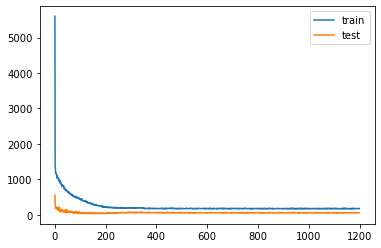

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

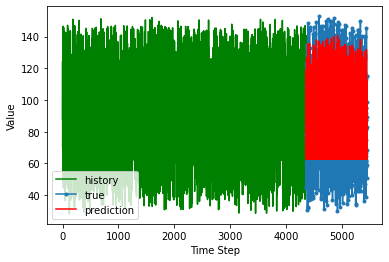

In [20]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

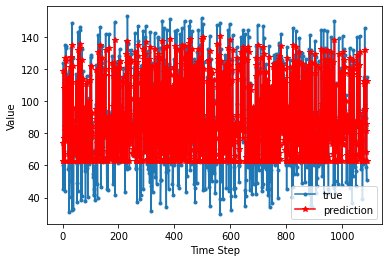

In [21]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [22]:
print(y_pred)

[[ 73.8823]
 [ 62.7211]
 [ 62.8087]
 ...
 [ 62.7491]
 [ 62.7213]
 [112.2256]]


In [23]:
print(y_test)

[[ 74.45]
 [ 45.45]
 [ 60.4 ]
 ...
 [ 58.95]
 [ 50.9 ]
 [115.  ]]


In [24]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.9290968010449245

In [25]:
#model.save('HSBC_FeatureSelected')

In [26]:
data_unseen

,Open,High,Low,Close,Volume,6day MA,12day MA,%R5,MTM6,MTM12,EMA12,EMA26,MACD,TR,OSC12,Prediction
Date,,,,,,,,,,,,,,,,
2021-12-10,45.099998,45.400002,44.950001,45.200001,6090109,45.225000,44.670833,-44.117627,1.200001,-0.899998,45.030425,45.087544,-0.057119,0.450001,2.319515,45.099998
2021-12-13,45.200001,45.250000,44.500000,45.099998,10861423,45.266666,44.583333,-54.838884,0.250000,-1.050003,45.041129,45.088466,-0.047338,0.750000,0.128164,44.500000
2021-12-14,44.150002,44.599998,44.150002,44.500000,7998591,45.208333,44.595833,-80.555632,-0.349998,0.150002,44.957878,45.044876,-0.086998,0.949997,-12.182049,44.950001
2021-12-15,44.700001,45.400002,44.450001,44.950001,11227978,45.091667,44.695833,-54.285758,-0.700001,1.200001,44.956666,45.037848,-0.081182,0.950001,-1.928878,45.150002
2021-12-16,44.849998,45.150002,44.299999,45.150002,9989350,45.033333,44.879167,-20.000000,-0.349998,2.200001,44.986410,45.046156,-0.059746,0.850002,2.396339,46.400002


In [27]:
unseen_x=data_unseen.drop('Prediction',1).values.reshape(5,nof)
unseen_x=scaler.transform(unseen_x).reshape(5,1,nof)
unseen_pred=model.predict(unseen_x)
# unseen_pred=scaler_y.inverse_transform(unseen_pred.flatten().reshape(-1,1))

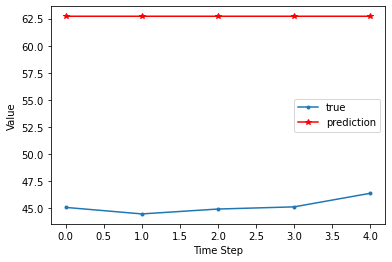

In [28]:
plt.plot(data_unseen['Prediction'].values, marker='.', label="true")
plt.plot(unseen_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [29]:
r2_score(data_unseen['Prediction'].values,unseen_pred)

-764.5600418973072